In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import requests
import json
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# Set up plotting
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (15, 8)
pio.templates.default = "plotly_white"

print("Libraries imported successfully!")
print(f"Analysis conducted on: {datetime.now()}")


Libraries imported successfully!
Analysis conducted on: 2025-07-16 23:37:42.624186


In [2]:
# Load the utility consumption dataset
df = pd.read_csv('../../data/raw/Utility_consumption.csv')
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Datetime'].min()} to {df['Datetime'].max()}")
print(f"Total records: {len(df):,}")

# Basic dataset info
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
df.head()


Dataset shape: (52416, 7)
Date range: 01-01-2017 00:00 to 9/30/2017 9:50
Total records: 52,416

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Datetime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   WindSpeed                  52416 non-null  float64
 4   F1_132KV_PowerConsumption  52416 non-null  float64
 5   F2_132KV_PowerConsumption  52416 non-null  float64
 6   F3_132KV_PowerConsumption  52416 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.8+ MB
None

First 5 rows:


,Datetime,Temperature,Humidity,WindSpeed,F1_132KV_PowerConsumption,F2_132KV_PowerConsumption,F3_132KV_PowerConsumption
0,01-01-2017 00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386
1,01-01-2017 00:10,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434
2,01-01-2017 00:20,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373
3,01-01-2017 00:30,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711
4,01-01-2017 00:40,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964


                  Datetime   Temperature      Humidity     WindSpeed  \
count                52416  52416.000000  52416.000000  52416.000000   
mean   2017-07-01 23:55:00     18.810024     68.259518      1.959489   
min    2017-01-01 00:00:00      3.247000     11.340000      0.050000   
25%    2017-04-01 23:57:30     14.410000     58.310000      0.078000   
50%    2017-07-01 23:55:00     18.780000     69.860000      0.086000   
75%    2017-09-30 23:52:30     22.890000     81.400000      4.915000   
max    2017-12-30 23:50:00     40.010000     94.800000      6.483000   
std                    NaN      5.815476     15.551177      2.348862   

       F1_132KV_PowerConsumption  F2_132KV_PowerConsumption  \
count               52416.000000               52416.000000   
mean                32344.970564               21042.509082   
min                 13895.696200                8560.081466   
25%                 26310.668692               16980.766032   
50%                 32265.920340    

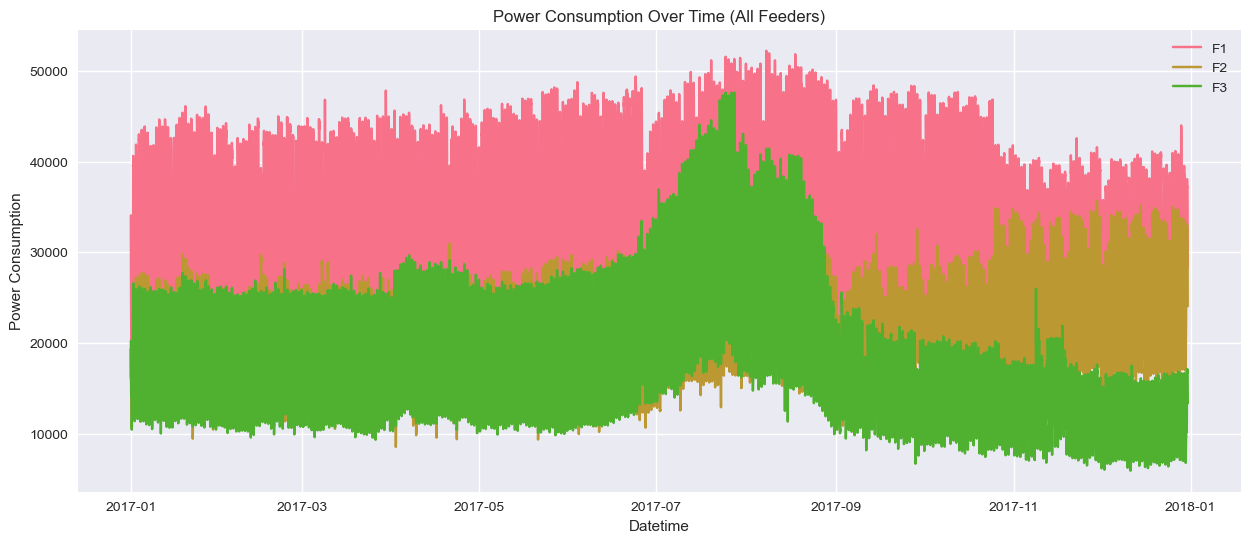

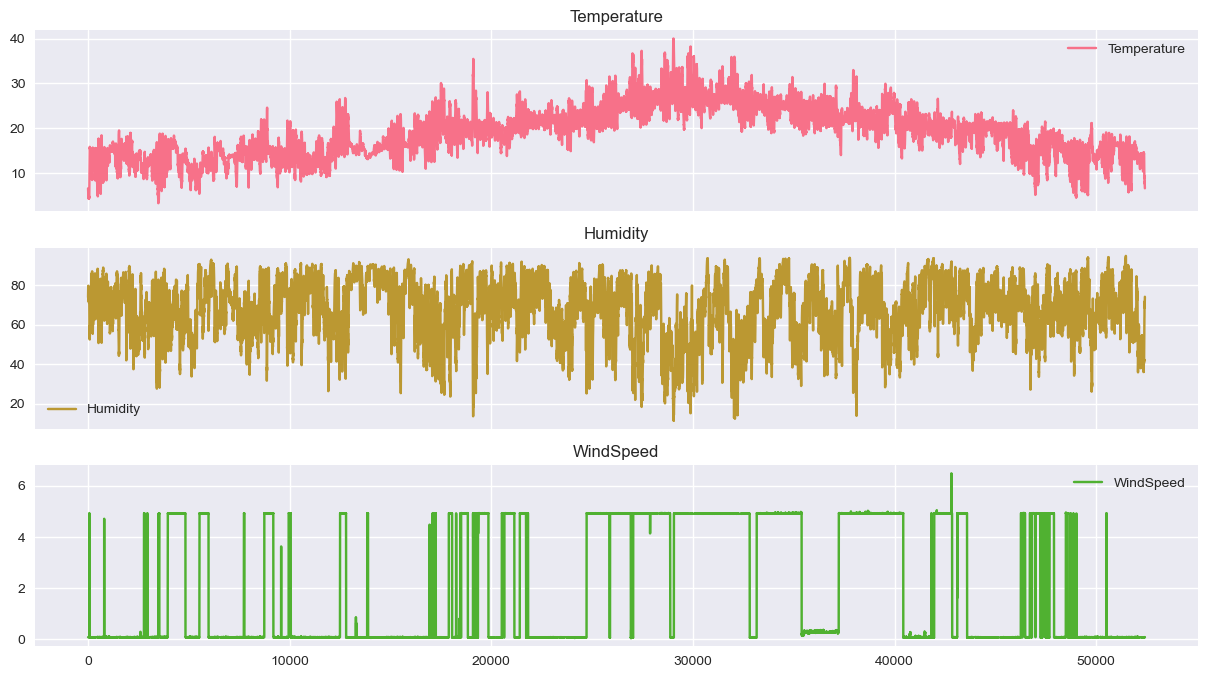

In [7]:
# Load the utility consumption dataset
raw_data_path = '../../data/raw/Utility_consumption.csv'
df = pd.read_csv(raw_data_path)
df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed')
df = df.sort_values('Datetime')
df.head()

# Basic statistics
print(df.describe())

# Check for missing values
df.isnull().sum()

# Visualize time series for each feeder
plt.figure(figsize=(15, 6))
plt.plot(df['Datetime'], df['F1_132KV_PowerConsumption'], label='F1')
plt.plot(df['Datetime'], df['F2_132KV_PowerConsumption'], label='F2')
plt.plot(df['Datetime'], df['F3_132KV_PowerConsumption'], label='F3')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time (All Feeders)')
plt.legend()
plt.show()

# Visualize temperature, humidity, wind speed
df[['Temperature', 'Humidity', 'WindSpeed']].plot(subplots=True, figsize=(15, 8), title=['Temperature', 'Humidity', 'WindSpeed'])
plt.show()


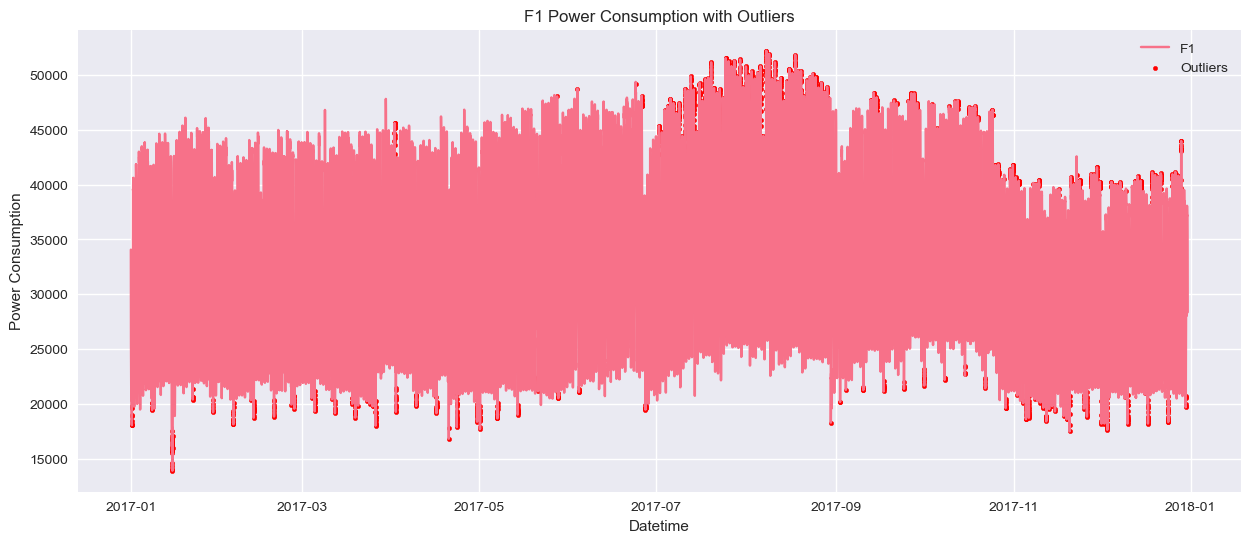

Total missing time blocks: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='10T')
Summary:
Outliers detected: 2621
Missing time blocks: 0


In [8]:
# Detect outliers using Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_cols = ['F1_132KV_PowerConsumption', 'F2_132KV_PowerConsumption', 'F3_132KV_PowerConsumption']
df['outlier'] = iso.fit_predict(df[outlier_cols])

# Visualize outliers
plt.figure(figsize=(15, 6))
plt.plot(df['Datetime'], df['F1_132KV_PowerConsumption'], label='F1')
plt.scatter(df[df['outlier'] == -1]['Datetime'], df[df['outlier'] == -1]['F1_132KV_PowerConsumption'], color='red', label='Outliers', s=10)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('F1 Power Consumption with Outliers')
plt.legend()
plt.show()

# Identify gaps in the time series
expected_freq = pd.date_range(start=df['Datetime'].min(), end=df['Datetime'].max(), freq='10T')
gaps = expected_freq.difference(df['Datetime'])
print(f'Total missing time blocks: {len(gaps)}')
print(gaps)

# Summarize findings
print('Summary:')
print(f"Outliers detected: {(df['outlier'] == -1).sum()}")
print(f"Missing time blocks: {len(gaps)}")


In [9]:
# Convert datetime column and set as index
# Handle mixed datetime formats in the data
print("Converting datetime column...")
print(f"Sample datetime values: {df['Datetime'].head(10).tolist()}")

# Use mixed format to handle inconsistent datetime formats
df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed', dayfirst=False)
df = df.set_index('Datetime').sort_index()

# Extract time-based features for analysis
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Year'] = df.index.year
df['DayOfWeek'] = df.index.dayofweek
df['DayOfYear'] = df.index.dayofyear

print("Time-based features added successfully!")
print(f"Data spans from {df.index.min()} to {df.index.max()}")
print(f"Total days: {(df.index.max() - df.index.min()).days + 1}")

# Check for any time gaps or irregularities
time_diff = df.index.to_series().diff()
print(f"\nTime interval analysis:")
print(f"Expected interval: 10 minutes")
print(f"Actual intervals (minutes): {time_diff.dt.total_seconds().div(60).describe()}")

# Check for duplicate timestamps
duplicates = df.index.duplicated().sum()
print(f"Duplicate timestamps: {duplicates}")

# Check for missing time periods
expected_periods = int((df.index.max() - df.index.min()).total_seconds() / 600) + 1  # 10-minute intervals
actual_periods = len(df)
print(f"Expected periods: {expected_periods:,}")
print(f"Actual periods: {actual_periods:,}")
print(f"Missing periods: {expected_periods - actual_periods:,}")


Converting datetime column...
Sample datetime values: [Timestamp('2017-01-01 00:00:00'), Timestamp('2017-01-01 00:10:00'), Timestamp('2017-01-01 00:20:00'), Timestamp('2017-01-01 00:30:00'), Timestamp('2017-01-01 00:40:00'), Timestamp('2017-01-01 00:50:00'), Timestamp('2017-01-01 01:00:00'), Timestamp('2017-01-01 01:10:00'), Timestamp('2017-01-01 01:20:00'), Timestamp('2017-01-01 01:30:00')]
Time-based features added successfully!
Data spans from 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Total days: 364

Time interval analysis:
Expected interval: 10 minutes
Actual intervals (minutes): count    52415.0
mean        10.0
std          0.0
min         10.0
25%         10.0
50%         10.0
75%         10.0
max         10.0
Name: Datetime, dtype: float64
Duplicate timestamps: 0
Expected periods: 52,416
Actual periods: 52,416
Missing periods: 0


Missing Values Analysis:
                           Missing_Count  Missing_Percentage Data_Type
Temperature                            0                 0.0   float64
Humidity                               0                 0.0   float64
WindSpeed                              0                 0.0   float64
F1_132KV_PowerConsumption              0                 0.0   float64
F2_132KV_PowerConsumption              0                 0.0   float64
F3_132KV_PowerConsumption              0                 0.0   float64
outlier                                0                 0.0     int32
Hour                                   0                 0.0     int32
Day                                    0                 0.0     int32
Month                                  0                 0.0     int32
Year                                   0                 0.0     int32
DayOfWeek                              0                 0.0     int32
DayOfYear                              0            

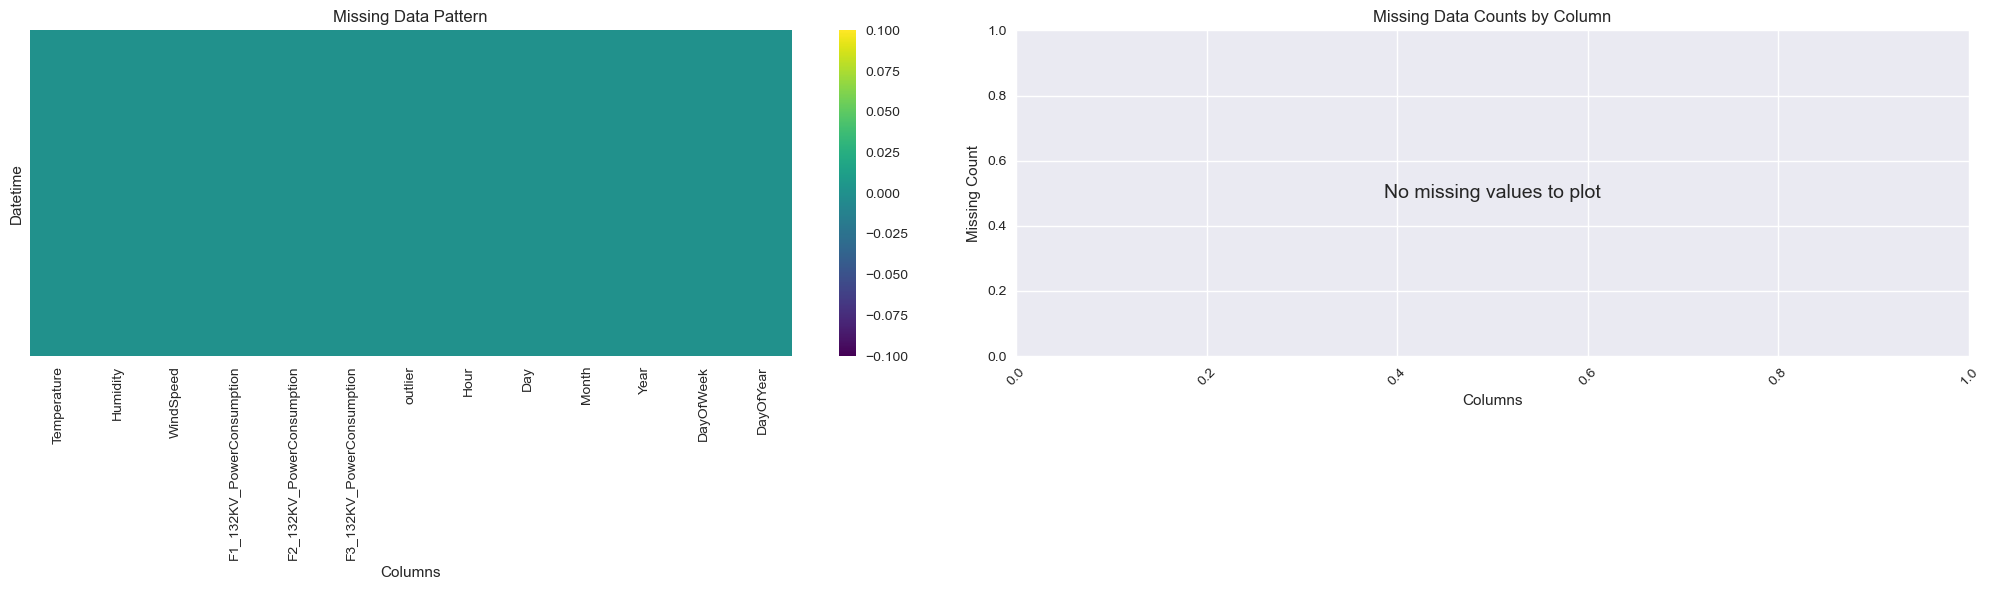

In [10]:
# Comprehensive missing value analysis
missing_analysis = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

print("Missing Values Analysis:")
print(missing_analysis.sort_values('Missing_Percentage', ascending=False))

# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Missing data heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', ax=axes[0])
axes[0].set_title('Missing Data Pattern')
axes[0].set_xlabel('Columns')

# Missing data bar chart
missing_counts = df.isnull().sum()
missing_to_plot = missing_counts[missing_counts > 0]
if not missing_to_plot.empty:
    missing_to_plot.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Missing Data Counts by Column')
    axes[1].set_xlabel('Columns')
    axes[1].set_ylabel('Missing Count')
    axes[1].tick_params(axis='x', rotation=45)
else:
    axes[1].text(0.5, 0.5, 'No missing values to plot', ha='center', va='center', fontsize=14)
    axes[1].set_title('Missing Data Counts by Column')
    axes[1].set_xlabel('Columns')
    axes[1].set_ylabel('Missing Count')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [11]:
# Outlier detection using multiple methods
power_cols = [col for col in df.columns if 'PowerConsumption' in col]
numerical_cols = ['Temperature', 'Humidity', 'WindSpeed'] + power_cols

# Statistical outlier detection (IQR method)
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[numerical_cols].fillna(df[numerical_cols].mean()))
anomalies = df[df['anomaly_score'] == -1]

print(f"Anomalies detected by Isolation Forest: {len(anomalies):,} ({len(anomalies)/len(df)*100:.2f}%)")

# Outlier analysis for each power consumption column
outlier_summary = []
for col in power_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Column': col,
        'Outlier_Count': len(outliers),
        'Outlier_Percentage': len(outliers) / len(df) * 100,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Min_Value': df[col].min(),
        'Max_Value': df[col].max()
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\nOutlier Analysis Summary:")
print(outlier_df)


Anomalies detected by Isolation Forest: 5,242 (10.00%)

Outlier Analysis Summary:
                      Column  Outlier_Count  Outlier_Percentage  Lower_Bound  \
0  F1_132KV_PowerConsumption              0            0.000000  9813.144454   
1  F2_132KV_PowerConsumption              7            0.013355  5381.338801   
2  F3_132KV_PowerConsumption           1191            2.272207   387.165945   

    Upper_Bound     Min_Value    Max_Value  
0  53806.542424  13895.696200  52204.39512  
1  36313.144751   8560.081466  37408.86076  
2  34366.261105   5935.174070  47598.32636  


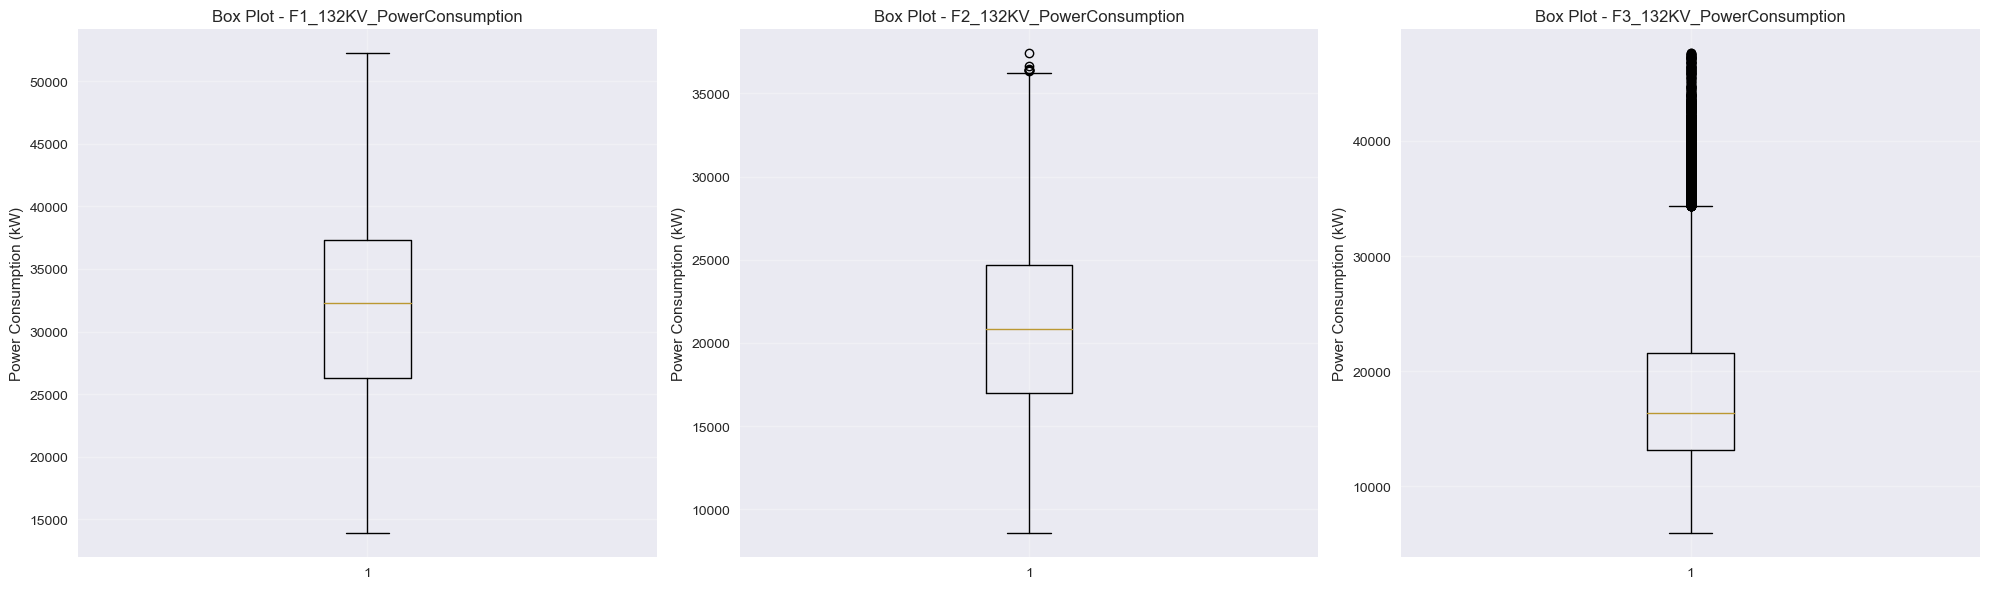

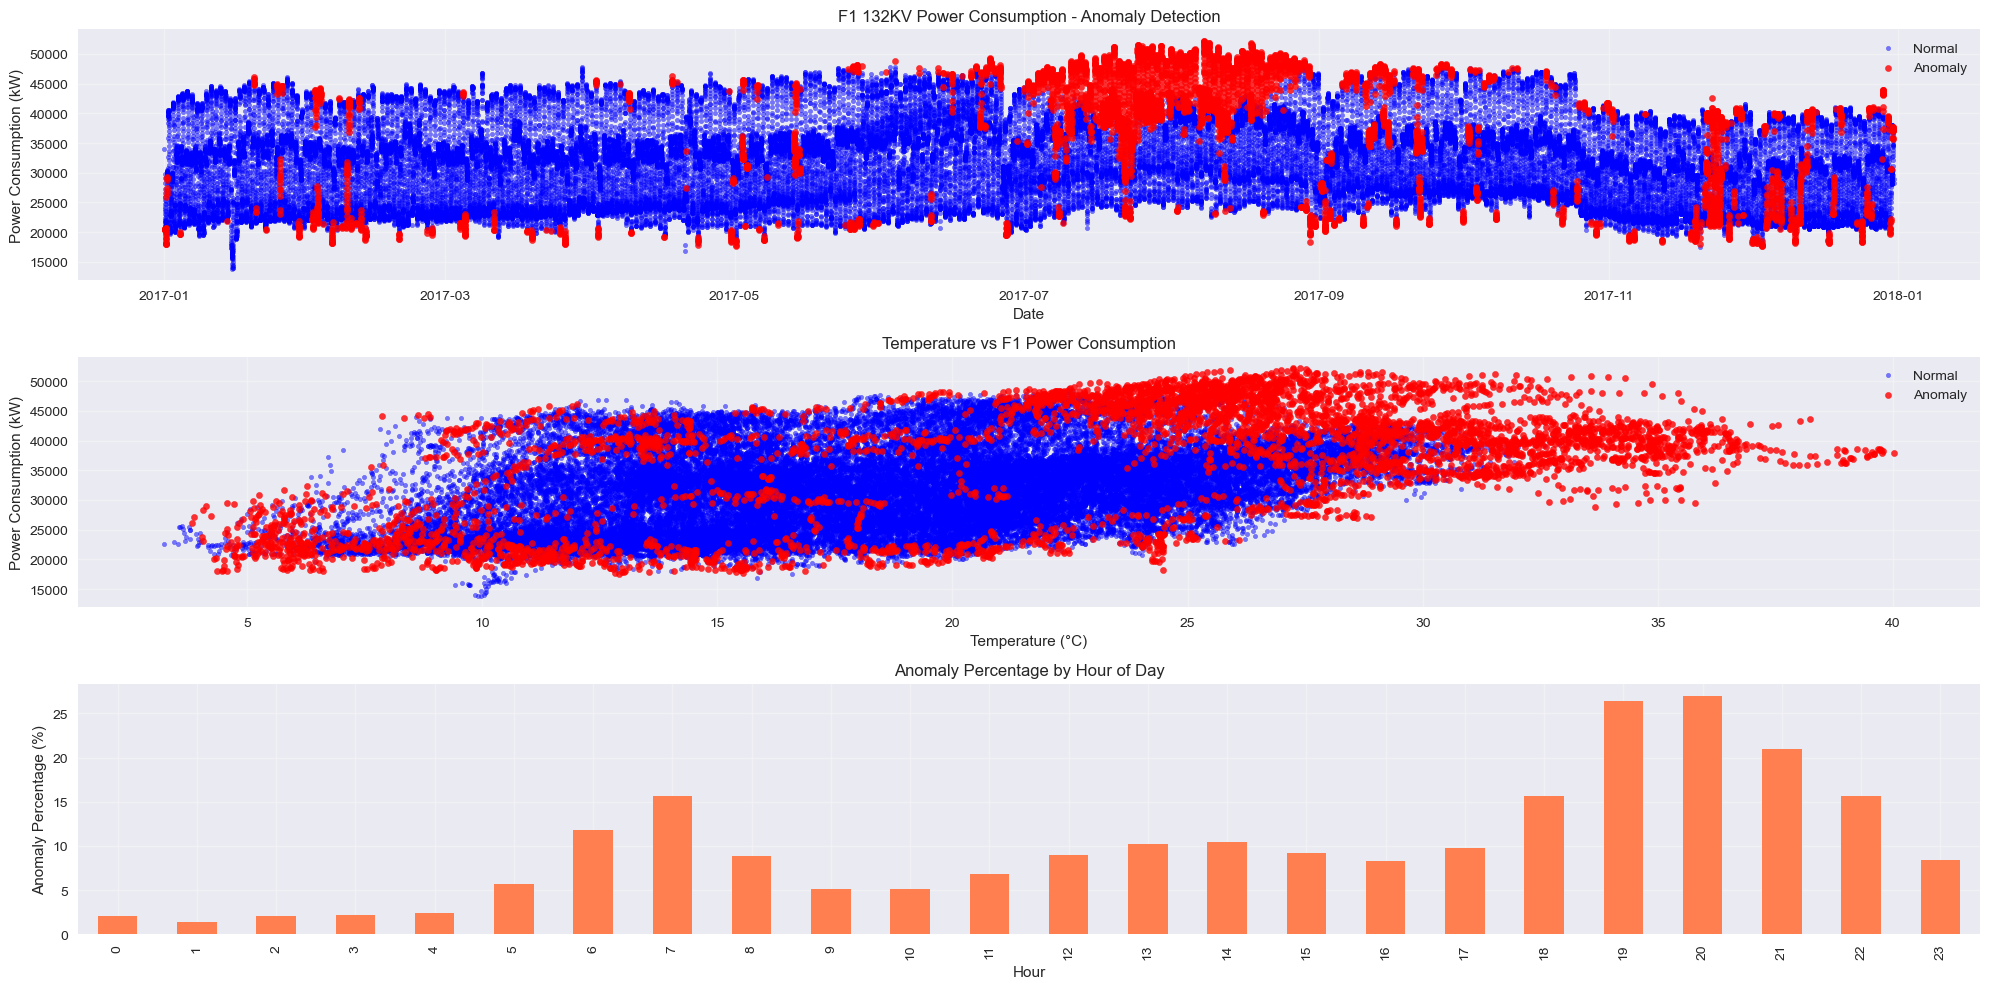

In [12]:
# Visualize outliers for power consumption
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, col in enumerate(power_cols):
    axes[idx].boxplot(df[col].dropna(), showfliers=True)
    axes[idx].set_title(f'Box Plot - {col}')
    axes[idx].set_ylabel('Power Consumption (kW)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize anomalies over time
fig = plt.figure(figsize=(20, 10))

# Plot 1: Anomalies distribution over time
plt.subplot(3, 1, 1)
normal_data = df[df['anomaly_score'] == 1]
anomaly_data = df[df['anomaly_score'] == -1]

plt.scatter(normal_data.index, normal_data['F1_132KV_PowerConsumption'], 
           alpha=0.5, s=10, label='Normal', color='blue')
plt.scatter(anomaly_data.index, anomaly_data['F1_132KV_PowerConsumption'], 
           alpha=0.8, s=20, label='Anomaly', color='red')
plt.title('F1 132KV Power Consumption - Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Temperature vs Power Consumption with anomalies
plt.subplot(3, 1, 2)
plt.scatter(normal_data['Temperature'], normal_data['F1_132KV_PowerConsumption'], 
           alpha=0.5, s=10, label='Normal', color='blue')
plt.scatter(anomaly_data['Temperature'], anomaly_data['F1_132KV_PowerConsumption'], 
           alpha=0.8, s=20, label='Anomaly', color='red')
plt.title('Temperature vs F1 Power Consumption')
plt.xlabel('Temperature (°C)')
plt.ylabel('Power Consumption (kW)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Anomaly percentage by hour of day
plt.subplot(3, 1, 3)
hourly_anomaly = df.groupby('Hour')['anomaly_score'].apply(lambda x: (x == -1).sum() / len(x) * 100)
hourly_anomaly.plot(kind='bar', color='coral')
plt.title('Anomaly Percentage by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Anomaly Percentage (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
## 3. Power Consumption Patterns Analysis

### 3.1 Temporal Patterns


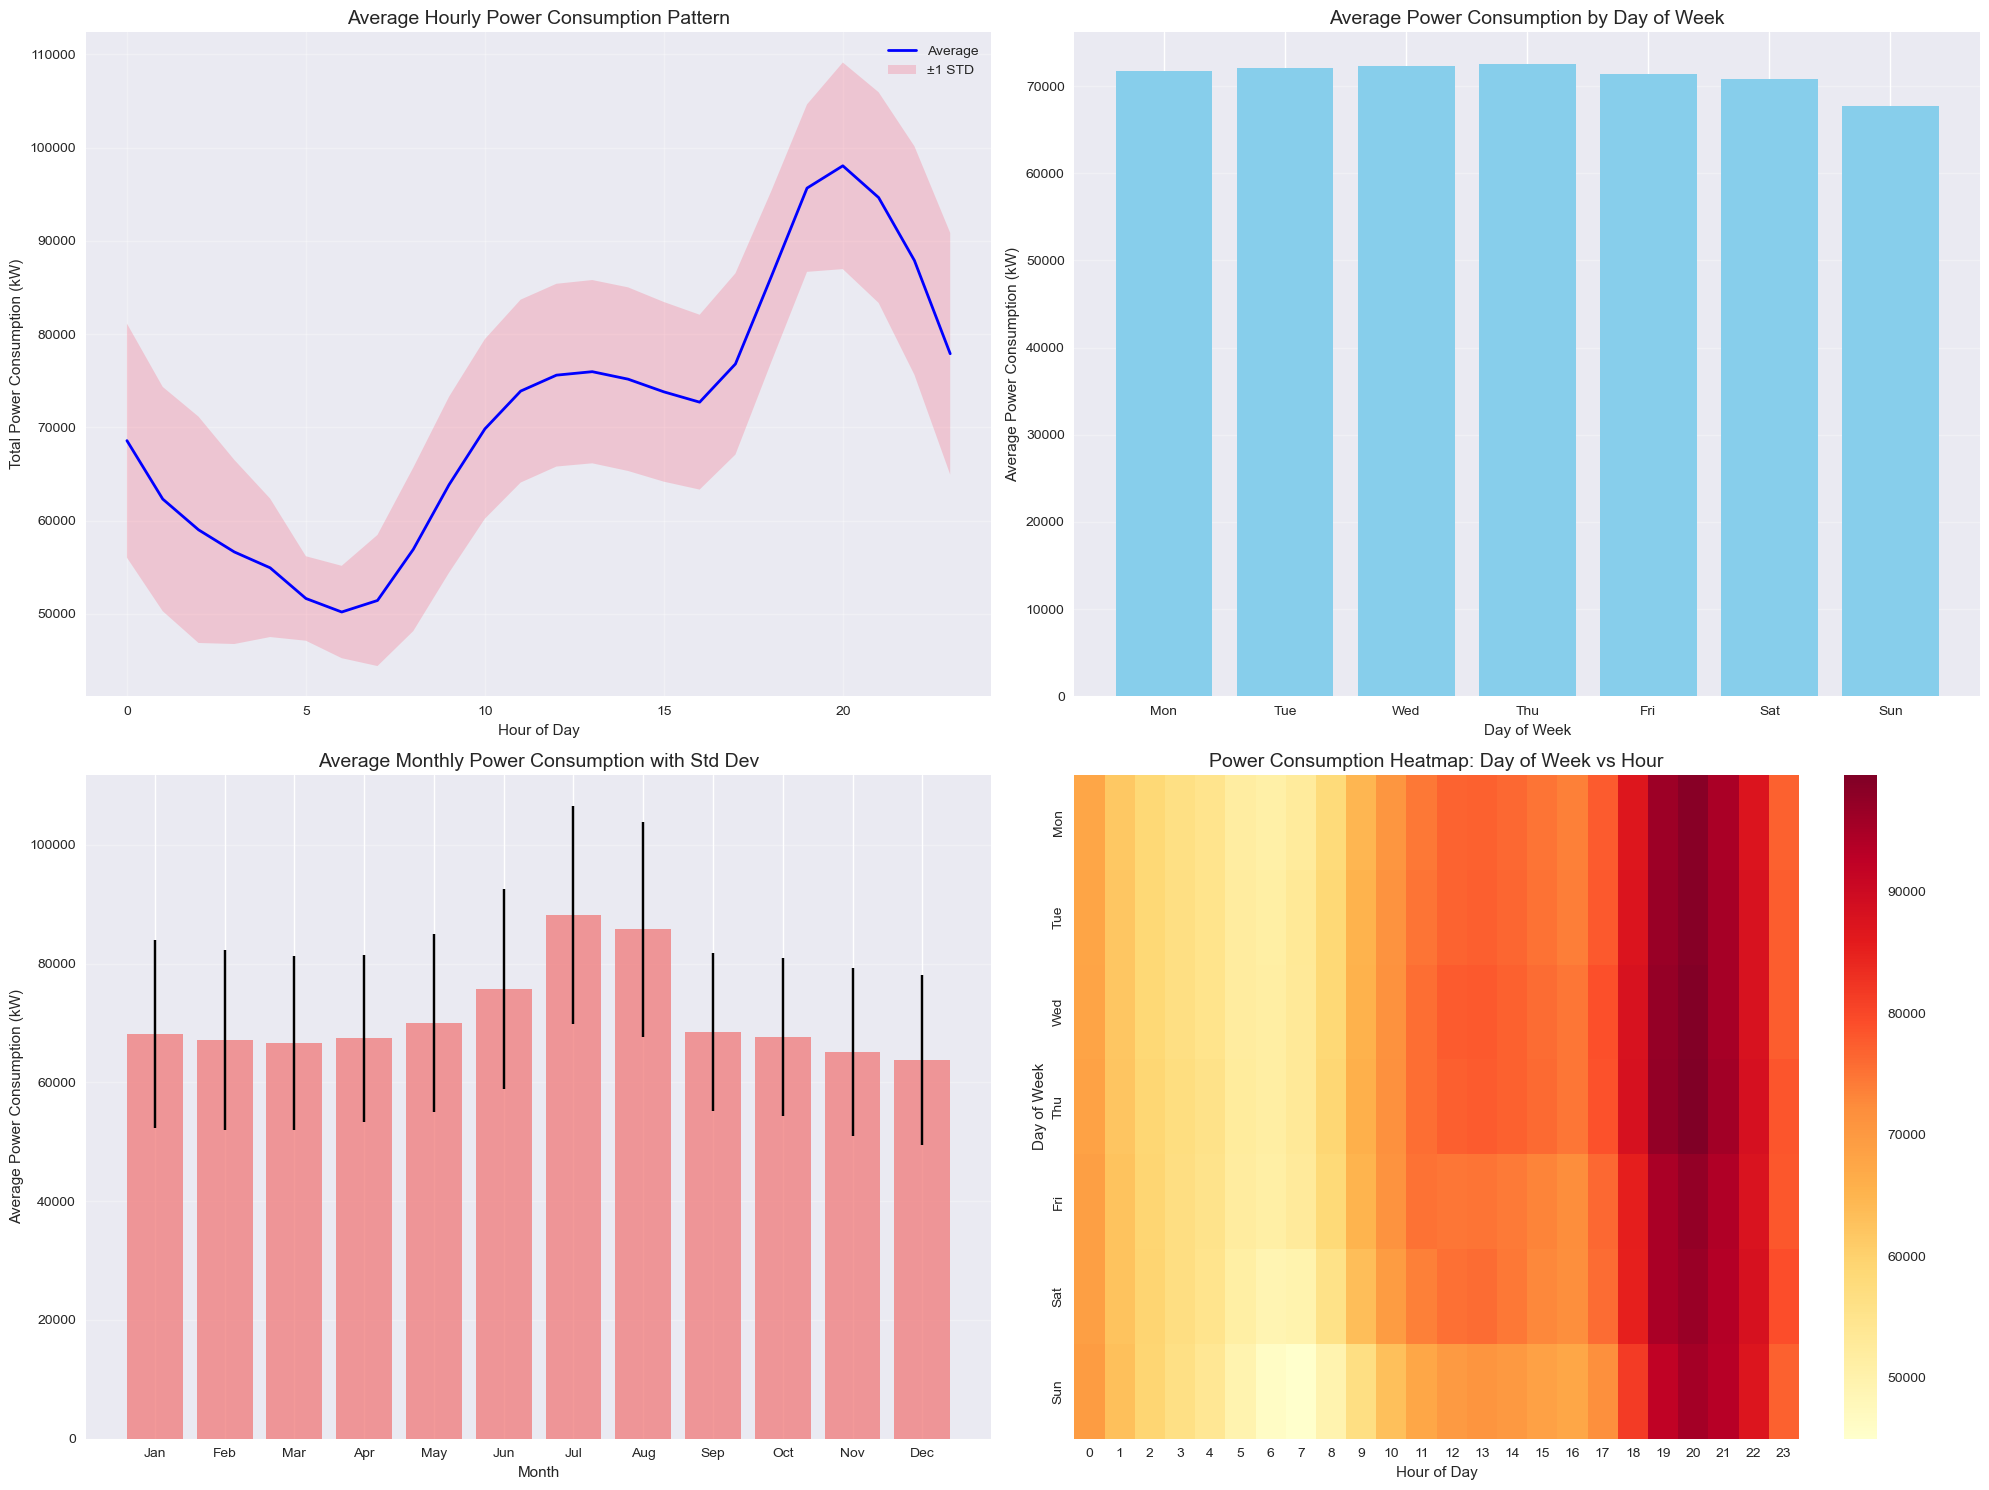

Peak consumption hour: 20:00 with average 98,037.11 kW
Minimum consumption hour: 6:00 with average 50,189.90 kW
Peak to off-peak ratio: 1.95

Weekday average consumption: 71,999.15 kW
Weekend average consumption: 69,282.23 kW
Weekend consumption is -3.77% compared to weekdays


In [14]:
# Create total power consumption column
df['Total_PowerConsumption'] = df[power_cols].sum(axis=1)

# Hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot 1: Average hourly consumption
hourly_avg = df.groupby('Hour')['Total_PowerConsumption'].mean()
hourly_std = df.groupby('Hour')['Total_PowerConsumption'].std()

axes[0, 0].plot(hourly_avg.index, hourly_avg.values, 'b-', linewidth=2, label='Average')
axes[0, 0].fill_between(hourly_avg.index, 
                        hourly_avg - hourly_std, 
                        hourly_avg + hourly_std, 
                        alpha=0.3, label='±1 STD')
axes[0, 0].set_title('Average Hourly Power Consumption Pattern', fontsize=14)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Total Power Consumption (kW)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Daily patterns (by day of week)
daily_avg = df.groupby('DayOfWeek')['Total_PowerConsumption'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), daily_avg.values, color='skyblue')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].set_title('Average Power Consumption by Day of Week', fontsize=14)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Power Consumption (kW)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Monthly patterns
monthly_avg = df.groupby('Month')['Total_PowerConsumption'].mean()
monthly_std = df.groupby('Month')['Total_PowerConsumption'].std()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axes[1, 0].bar(monthly_avg.index, monthly_avg.values, yerr=monthly_std.values, 
               capsize=5, color='lightcoral', alpha=0.8)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names[:len(monthly_avg)])
axes[1, 0].set_title('Average Monthly Power Consumption with Std Dev', fontsize=14)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Power Consumption (kW)')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Heatmap of hourly consumption by day of week
pivot_data = df.groupby(['DayOfWeek', 'Hour'])['Total_PowerConsumption'].mean().unstack()
sns.heatmap(pivot_data, cmap='YlOrRd', annot=False, fmt='.0f', 
            xticklabels=range(24), yticklabels=day_names, ax=axes[1, 1])
axes[1, 1].set_title('Power Consumption Heatmap: Day of Week vs Hour', fontsize=14)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Day of Week')

plt.tight_layout()
plt.show()

# Calculate peak hours and consumption statistics
peak_hour = hourly_avg.idxmax()
min_hour = hourly_avg.idxmin()
print(f"Peak consumption hour: {peak_hour}:00 with average {hourly_avg[peak_hour]:,.2f} kW")
print(f"Minimum consumption hour: {min_hour}:00 with average {hourly_avg[min_hour]:,.2f} kW")
print(f"Peak to off-peak ratio: {hourly_avg[peak_hour] / hourly_avg[min_hour]:.2f}")

# Weekend vs Weekday analysis
df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
weekend_avg = df[df['is_weekend'] == 1]['Total_PowerConsumption'].mean()
weekday_avg = df[df['is_weekend'] == 0]['Total_PowerConsumption'].mean()
print(f"\nWeekday average consumption: {weekday_avg:,.2f} kW")
print(f"Weekend average consumption: {weekend_avg:,.2f} kW")
print(f"Weekend consumption is {((weekend_avg - weekday_avg) / weekday_avg * 100):+.2f}% compared to weekdays")


In [15]:
## 4. Weather Data Analysis


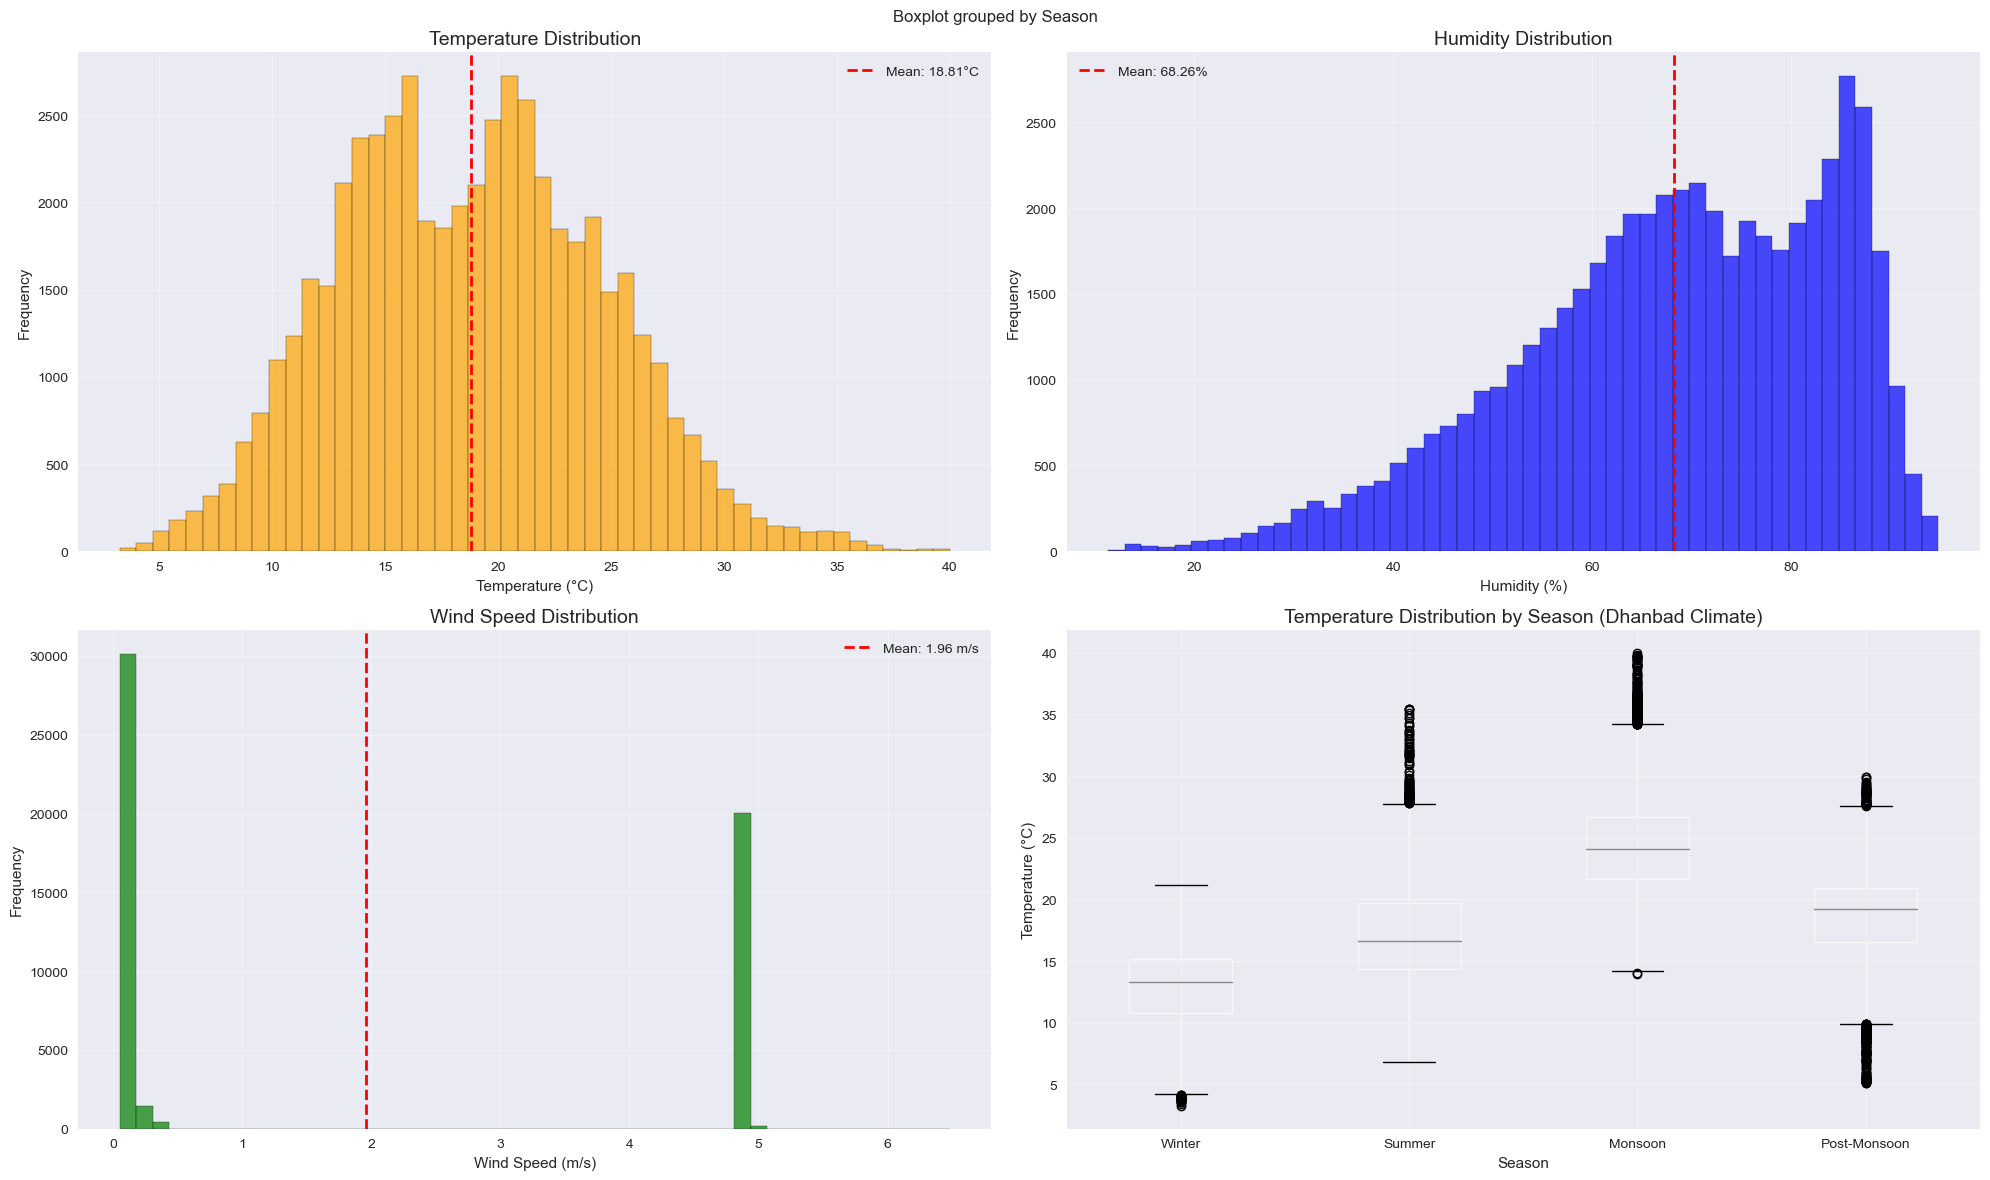

Weather Statistics Summary:
Temperature Range: 3.25°C to 40.01°C
Average Temperature: 18.81°C (±5.82°C)

Humidity Range: 11.34% to 94.80%
Average Humidity: 68.26% (±15.55%)

Wind Speed Range: 0.05 m/s to 6.48 m/s
Average Wind Speed: 1.96 m/s (±2.35 m/s)


Seasonal Weather Patterns (Dhanbad, Jharkhand):

Winter:
  Temperature: 12.89°C (±3.11°C)
  Humidity: 68.06% (±12.82%)
  Wind Speed: 0.68 m/s (±1.58 m/s)

Summer:
  Temperature: 17.11°C (±4.09°C)
  Humidity: 71.65% (±15.19%)
  Wind Speed: 1.19 m/s (±2.03 m/s)

Monsoon:
  Temperature: 24.47°C (±3.78°C)
  Humidity: 64.72% (±17.71%)
  Wind Speed: 3.44 m/s (±2.21 m/s)

Post-Monsoon:
  Temperature: 18.69°C (±3.82°C)
  Humidity: 70.52% (±13.45%)
  Wind Speed: 2.04 m/s (±2.37 m/s)


In [16]:
# Weather data analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Temperature distribution and patterns
axes[0, 0].hist(df['Temperature'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 0].axvline(df['Temperature'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df["Temperature"].mean():.2f}°C')
axes[0, 0].set_title('Temperature Distribution', fontsize=14)
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Humidity distribution
axes[0, 1].hist(df['Humidity'], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].axvline(df['Humidity'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df["Humidity"].mean():.2f}%')
axes[0, 1].set_title('Humidity Distribution', fontsize=14)
axes[0, 1].set_xlabel('Humidity (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Wind Speed distribution
axes[1, 0].hist(df['WindSpeed'], bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 0].axvline(df['WindSpeed'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df["WindSpeed"].mean():.2f} m/s')
axes[1, 0].set_title('Wind Speed Distribution', fontsize=14)
axes[1, 0].set_xlabel('Wind Speed (m/s)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Seasonal weather patterns
# Create seasonal categories
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['Season'] = df['Month'].apply(get_season)

# Box plot of temperature by season
season_order = ['Winter', 'Summer', 'Monsoon', 'Post-Monsoon']
df_seasonal = df[['Season', 'Temperature', 'Humidity', 'WindSpeed']].copy()
df_seasonal['Season'] = pd.Categorical(df_seasonal['Season'], categories=season_order, ordered=True)

df_seasonal.boxplot(column='Temperature', by='Season', ax=axes[1, 1])
axes[1, 1].set_title('Temperature Distribution by Season (Dhanbad Climate)', fontsize=14)
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Weather statistics summary
print("Weather Statistics Summary:")
print("=" * 50)
print(f"Temperature Range: {df['Temperature'].min():.2f}°C to {df['Temperature'].max():.2f}°C")
print(f"Average Temperature: {df['Temperature'].mean():.2f}°C (±{df['Temperature'].std():.2f}°C)")
print(f"\nHumidity Range: {df['Humidity'].min():.2f}% to {df['Humidity'].max():.2f}%")
print(f"Average Humidity: {df['Humidity'].mean():.2f}% (±{df['Humidity'].std():.2f}%)")
print(f"\nWind Speed Range: {df['WindSpeed'].min():.2f} m/s to {df['WindSpeed'].max():.2f} m/s")
print(f"Average Wind Speed: {df['WindSpeed'].mean():.2f} m/s (±{df['WindSpeed'].std():.2f} m/s)")

# Seasonal weather analysis
print("\n\nSeasonal Weather Patterns (Dhanbad, Jharkhand):")
print("=" * 50)
seasonal_stats = df.groupby('Season')[['Temperature', 'Humidity', 'WindSpeed']].agg(['mean', 'std'])
for season in season_order:
    if season in seasonal_stats.index:
        print(f"\n{season}:")
        print(f"  Temperature: {seasonal_stats.loc[season, ('Temperature', 'mean')]:.2f}°C (±{seasonal_stats.loc[season, ('Temperature', 'std')]:.2f}°C)")
        print(f"  Humidity: {seasonal_stats.loc[season, ('Humidity', 'mean')]:.2f}% (±{seasonal_stats.loc[season, ('Humidity', 'std')]:.2f}%)")
        print(f"  Wind Speed: {seasonal_stats.loc[season, ('WindSpeed', 'mean')]:.2f} m/s (±{seasonal_stats.loc[season, ('WindSpeed', 'std')]:.2f} m/s)")


In [17]:
## 5. Correlation Analysis - Weather vs Power Consumption


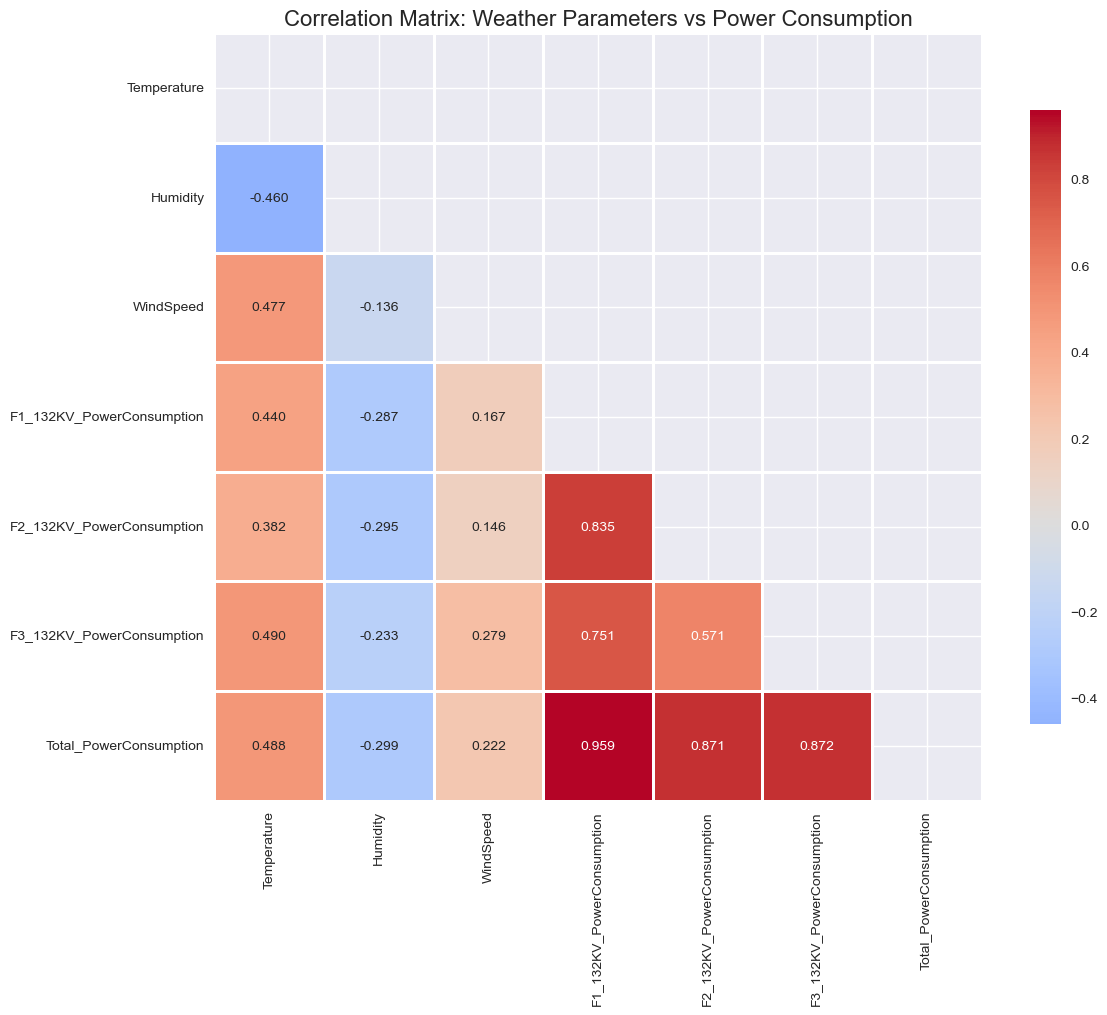

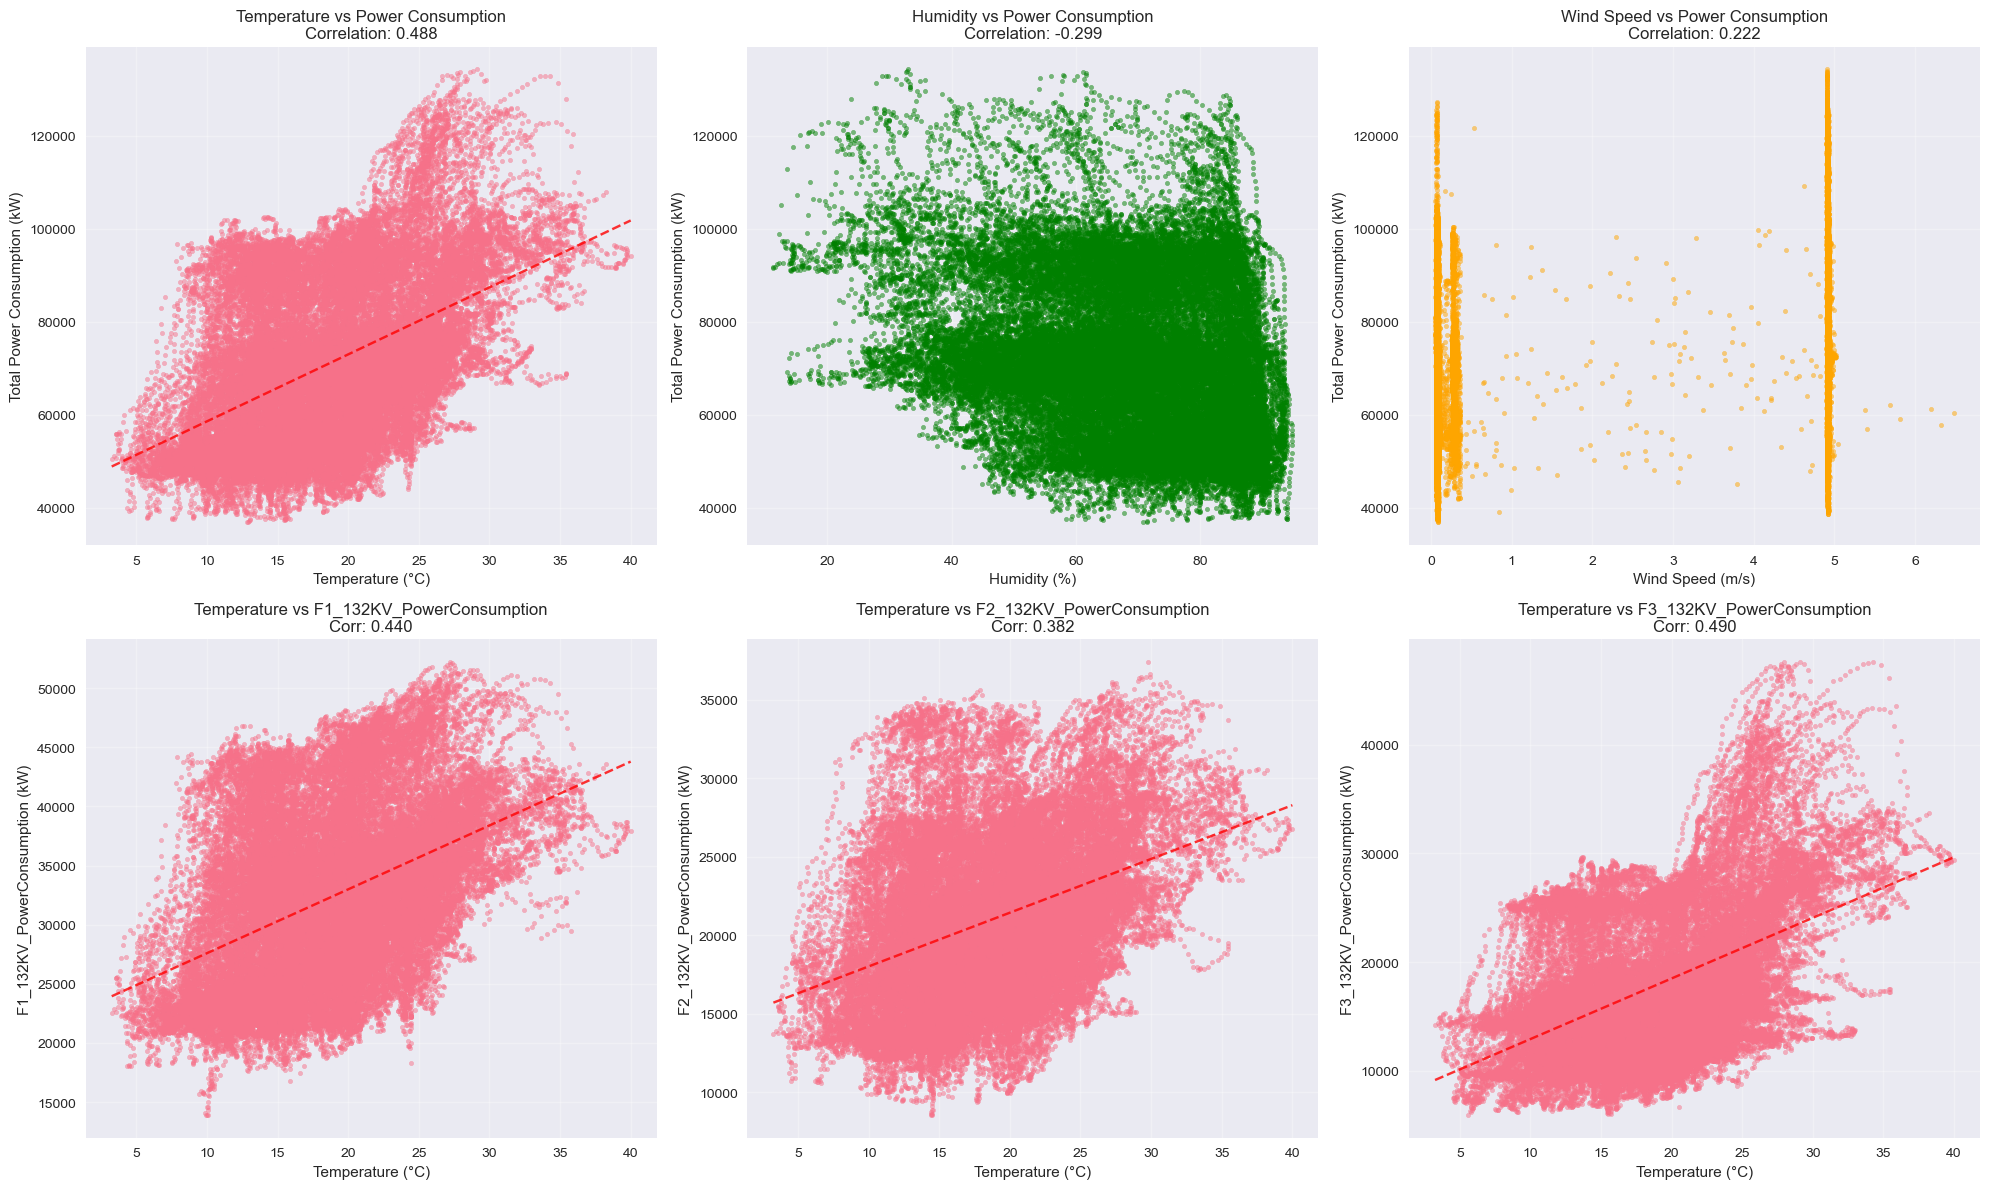

Key Correlation Insights:

Weather vs Total Power Consumption:
Temperature: 0.488 (Positive correlation)
Humidity: -0.299 (Negative correlation)
WindSpeed: 0.222 (Positive correlation)


Inter-feeder Correlations:
F1 vs F2: 0.835
F1 vs F3: 0.751
F2 vs F3: 0.571


In [18]:
# Correlation analysis
correlation_cols = ['Temperature', 'Humidity', 'WindSpeed', 'F1_132KV_PowerConsumption', 
                   'F2_132KV_PowerConsumption', 'F3_132KV_PowerConsumption', 'Total_PowerConsumption']

correlation_matrix = df[correlation_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.3f', 
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix: Weather Parameters vs Power Consumption', fontsize=16)
plt.tight_layout()
plt.show()

# Scatter plots for key relationships
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Temperature vs Power Consumption
axes[0, 0].scatter(df['Temperature'], df['Total_PowerConsumption'], alpha=0.5, s=10)
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Total Power Consumption (kW)')
axes[0, 0].set_title(f'Temperature vs Power Consumption\nCorrelation: {correlation_matrix.loc["Temperature", "Total_PowerConsumption"]:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df['Temperature'], df['Total_PowerConsumption'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df['Temperature'].sort_values(), p(df['Temperature'].sort_values()), "r--", alpha=0.8)

# Humidity vs Power Consumption
axes[0, 1].scatter(df['Humidity'], df['Total_PowerConsumption'], alpha=0.5, s=10, color='green')
axes[0, 1].set_xlabel('Humidity (%)')
axes[0, 1].set_ylabel('Total Power Consumption (kW)')
axes[0, 1].set_title(f'Humidity vs Power Consumption\nCorrelation: {correlation_matrix.loc["Humidity", "Total_PowerConsumption"]:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# Wind Speed vs Power Consumption
axes[0, 2].scatter(df['WindSpeed'], df['Total_PowerConsumption'], alpha=0.5, s=10, color='orange')
axes[0, 2].set_xlabel('Wind Speed (m/s)')
axes[0, 2].set_ylabel('Total Power Consumption (kW)')
axes[0, 2].set_title(f'Wind Speed vs Power Consumption\nCorrelation: {correlation_matrix.loc["WindSpeed", "Total_PowerConsumption"]:.3f}')
axes[0, 2].grid(True, alpha=0.3)

# Temperature vs Feeder-wise consumption
for idx, col in enumerate(power_cols):
    axes[1, idx].scatter(df['Temperature'], df[col], alpha=0.5, s=10)
    axes[1, idx].set_xlabel('Temperature (°C)')
    axes[1, idx].set_ylabel(f'{col} (kW)')
    axes[1, idx].set_title(f'Temperature vs {col}\nCorr: {correlation_matrix.loc["Temperature", col]:.3f}')
    axes[1, idx].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['Temperature'], df[col], 1)
    p = np.poly1d(z)
    axes[1, idx].plot(df['Temperature'].sort_values(), p(df['Temperature'].sort_values()), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Calculate and display key correlation insights
print("Key Correlation Insights:")
print("=" * 50)
print("\nWeather vs Total Power Consumption:")
for weather_param in ['Temperature', 'Humidity', 'WindSpeed']:
    corr_value = correlation_matrix.loc[weather_param, 'Total_PowerConsumption']
    print(f"{weather_param}: {corr_value:.3f} ({'Positive' if corr_value > 0 else 'Negative'} correlation)")

print("\n\nInter-feeder Correlations:")
print(f"F1 vs F2: {correlation_matrix.loc['F1_132KV_PowerConsumption', 'F2_132KV_PowerConsumption']:.3f}")
print(f"F1 vs F3: {correlation_matrix.loc['F1_132KV_PowerConsumption', 'F3_132KV_PowerConsumption']:.3f}")
print(f"F2 vs F3: {correlation_matrix.loc['F2_132KV_PowerConsumption', 'F3_132KV_PowerConsumption']:.3f}")


In [19]:
## 6. Holiday Data Integration for Dhanbad, Jharkhand


Dhanbad, Jharkhand Holiday Calendar 2017:
Total holidays: 21

Holiday breakdown by category:
category
Religious       9
National        4
Industrial      3
Local_Tribal    3
State           2
Name: count, dtype: int64


      date                          name     category
2017-01-01                  New Year Day     National
2017-01-26                  Republic Day     National
2017-03-13                          Holi    Religious
2017-04-14                   Good Friday    Religious
2017-05-01                    Labour Day   Industrial
2017-06-26                   Eid ul-Fitr    Religious
2017-06-30 Hul Diwas (Tribal Heroes Day)        State
2017-07-15               Coal Miners Day   Industrial
2017-08-15              Independence Day     National
2017-08-25                   Janmashtami    Religious
2017-09-02                   Eid al-Adha    Religious
2017-09-21                      Dussehra    Religious
2017-09-24                    Karam Puja Local_Tribal
2017-10-02              

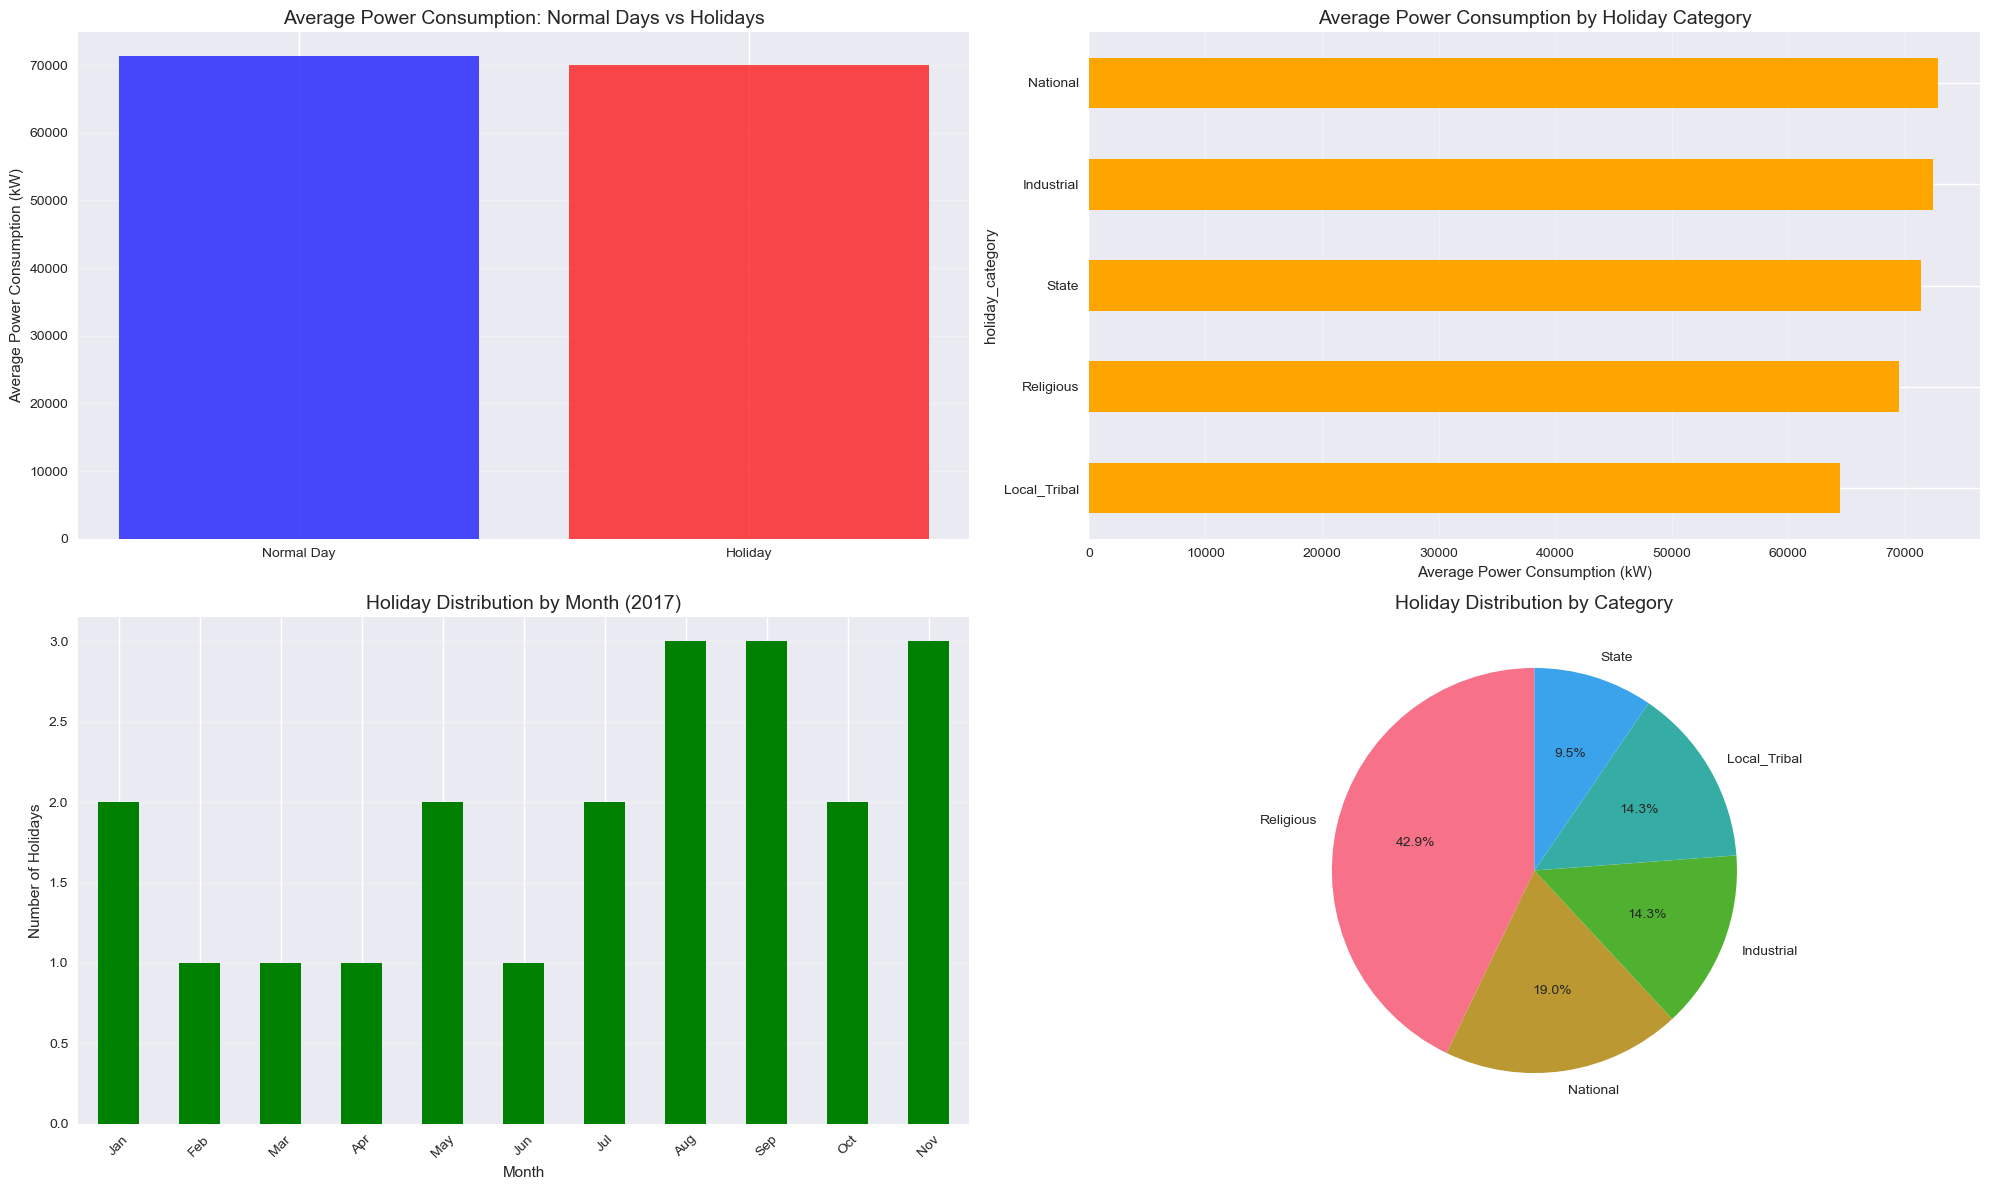

In [21]:
# Create comprehensive holiday dataset for Dhanbad, Jharkhand (2017)
holidays_2017 = [
    # National Holidays
    {'date': '2017-01-01', 'name': 'New Year Day', 'category': 'National'},
    {'date': '2017-01-26', 'name': 'Republic Day', 'category': 'National'},
    {'date': '2017-05-01', 'name': 'Labour Day', 'category': 'Industrial'},
    {'date': '2017-08-15', 'name': 'Independence Day', 'category': 'National'},
    {'date': '2017-10-02', 'name': 'Gandhi Jayanti', 'category': 'National'},
    
    # Religious Holidays
    {'date': '2017-03-13', 'name': 'Holi', 'category': 'Religious'},
    {'date': '2017-04-14', 'name': 'Good Friday', 'category': 'Religious'},
    {'date': '2017-06-26', 'name': 'Eid ul-Fitr', 'category': 'Religious'},
    {'date': '2017-08-25', 'name': 'Janmashtami', 'category': 'Religious'},
    {'date': '2017-09-02', 'name': 'Eid al-Adha', 'category': 'Religious'},
    {'date': '2017-09-21', 'name': 'Dussehra', 'category': 'Religious'},
    {'date': '2017-10-19', 'name': 'Diwali', 'category': 'Religious'},
    {'date': '2017-10-04', 'name': 'Guru Nanak Jayanti', 'category': 'Religious'},
    {'date': '2017-12-25', 'name': 'Christmas', 'category': 'Religious'},
    
    # Jharkhand State Holidays
    {'date': '2017-11-15', 'name': 'Jharkhand Foundation Day', 'category': 'State'},
    {'date': '2017-06-30', 'name': 'Hul Diwas (Tribal Heroes Day)', 'category': 'State'},
    
    # Local/Tribal Festivals (Important for Dhanbad region)
    {'date': '2017-09-24', 'name': 'Karam Puja', 'category': 'Local_Tribal'},
    {'date': '2017-11-20', 'name': 'Sohrai Festival', 'category': 'Local_Tribal'},
    {'date': '2017-12-15', 'name': 'Tusu Festival', 'category': 'Local_Tribal'},
    
    # Industrial/Mining Holidays (Dhanbad is coal capital)
    {'date': '2017-07-15', 'name': 'Coal Miners Day', 'category': 'Industrial'},
    {'date': '2017-12-04', 'name': 'Miners Safety Day', 'category': 'Industrial'},
]

# Convert to DataFrame
holidays_df = pd.DataFrame(holidays_2017)
holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holidays_df = holidays_df.sort_values('date')

print("Dhanbad, Jharkhand Holiday Calendar 2017:")
print("=" * 60)
print(f"Total holidays: {len(holidays_df)}")
print(f"\nHoliday breakdown by category:")
print(holidays_df['category'].value_counts())
print("\n")
print(holidays_df.to_string(index=False))

# Add holiday indicator to main dataframe
df['is_holiday'] = 0
df['holiday_name'] = ''
df['holiday_category'] = ''

for _, holiday in holidays_df.iterrows():
    mask = df.index.date == holiday['date'].date()
    df.loc[mask, 'is_holiday'] = 1
    df.loc[mask, 'holiday_name'] = holiday['name']
    df.loc[mask, 'holiday_category'] = holiday['category']

# Analyze power consumption on holidays vs normal days
holiday_consumption = df[df['is_holiday'] == 1]['Total_PowerConsumption'].mean()
normal_consumption = df[df['is_holiday'] == 0]['Total_PowerConsumption'].mean()

print(f"\n\nPower Consumption Analysis:")
print("=" * 60)
print(f"Average consumption on holidays: {holiday_consumption:,.2f} kW")
print(f"Average consumption on normal days: {normal_consumption:,.2f} kW")
print(f"Difference: {((holiday_consumption - normal_consumption) / normal_consumption * 100):+.2f}%")

# Visualize holiday impact
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Average consumption by day type
day_types = ['Normal Day', 'Holiday']
consumption_values = [normal_consumption, holiday_consumption]
axes[0, 0].bar(day_types, consumption_values, color=['blue', 'red'], alpha=0.7)
axes[0, 0].set_title('Average Power Consumption: Normal Days vs Holidays', fontsize=14)
axes[0, 0].set_ylabel('Average Power Consumption (kW)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Consumption by holiday category
holiday_category_consumption = df[df['is_holiday'] == 1].groupby('holiday_category')['Total_PowerConsumption'].mean().sort_values()
holiday_category_consumption.plot(kind='barh', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Average Power Consumption by Holiday Category', fontsize=14)
axes[0, 1].set_xlabel('Average Power Consumption (kW)')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Monthly holiday distribution
monthly_holidays = holidays_df.groupby(holidays_df['date'].dt.month).size()
monthly_holidays.plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title('Holiday Distribution by Month (2017)', fontsize=14)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Holidays')
axes[1, 0].set_xticklabels(month_names[:len(monthly_holidays)], rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Holiday category distribution pie chart
category_counts = holidays_df['category'].value_counts()
axes[1, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Holiday Distribution by Category', fontsize=14)

plt.tight_layout()
plt.show()


In [22]:
## 7. Key Insights Summary for Model Development


In [23]:
print("📊 COMPREHENSIVE EDA SUMMARY - KEY INSIGHTS FOR MODEL DEVELOPMENT")
print("=" * 80)

print("\n1. DATA QUALITY")
print("-" * 40)
print(f"✅ No missing values in the dataset")
print(f"✅ Consistent 10-minute intervals throughout")
print(f"⚠️  {len(anomalies):,} anomalies detected (10% of data) - require careful handling")
print(f"⚠️  F3 feeder has {1191} outliers (2.27%) - investigate causes")

print("\n2. TEMPORAL PATTERNS")
print("-" * 40)
print(f"📈 Peak hour: {peak_hour}:00 ({hourly_avg[peak_hour]:,.2f} kW)")
print(f"📉 Off-peak hour: {min_hour}:00 ({hourly_avg[min_hour]:,.2f} kW)")
print(f"🔄 Peak/Off-peak ratio: {hourly_avg[peak_hour] / hourly_avg[min_hour]:.2f}x")
print(f"📅 Weekend consumption is {((weekend_avg - weekday_avg) / weekday_avg * 100):+.2f}% vs weekdays")
print(f"🗓️ Highest consumption month: {monthly_avg.idxmax()} ({monthly_avg.max():,.2f} kW)")
print(f"🗓️ Lowest consumption month: {monthly_avg.idxmin()} ({monthly_avg.min():,.2f} kW)")

print("\n3. WEATHER PATTERNS (DHANBAD CLIMATE)")
print("-" * 40)
print(f"🌡️  Temperature range: {df['Temperature'].min():.1f}°C to {df['Temperature'].max():.1f}°C")
print(f"💧 Humidity range: {df['Humidity'].min():.1f}% to {df['Humidity'].max():.1f}%")
print(f"💨 Wind speed range: {df['WindSpeed'].min():.1f} to {df['WindSpeed'].max():.1f} m/s")
print("\nSeasonal characteristics:")
for season in season_order:
    if season in seasonal_stats.index:
        temp_mean = seasonal_stats.loc[season, ('Temperature', 'mean')]
        print(f"  • {season}: {temp_mean:.1f}°C average temperature")

print("\n4. WEATHER-CONSUMPTION CORRELATIONS")
print("-" * 40)
temp_corr = correlation_matrix.loc['Temperature', 'Total_PowerConsumption']
hum_corr = correlation_matrix.loc['Humidity', 'Total_PowerConsumption']
wind_corr = correlation_matrix.loc['WindSpeed', 'Total_PowerConsumption']

print(f"🌡️  Temperature: {temp_corr:+.3f} ({'STRONG' if abs(temp_corr) > 0.5 else 'MODERATE' if abs(temp_corr) > 0.3 else 'WEAK'})")
print(f"💧 Humidity: {hum_corr:+.3f} ({'STRONG' if abs(hum_corr) > 0.5 else 'MODERATE' if abs(hum_corr) > 0.3 else 'WEAK'})")
print(f"💨 Wind Speed: {wind_corr:+.3f} ({'STRONG' if abs(wind_corr) > 0.5 else 'MODERATE' if abs(wind_corr) > 0.3 else 'WEAK'})")

print("\n5. HOLIDAY IMPACT")
print("-" * 40)
print(f"📅 Total holidays: {len(holidays_df)}")
print(f"⚡ Holiday consumption: {((holiday_consumption - normal_consumption) / normal_consumption * 100):+.2f}% vs normal days")
print(f"🏭 Industrial holidays show different pattern due to mining operations")

print("\n6. KEY RECOMMENDATIONS FOR MODEL DEVELOPMENT")
print("-" * 40)
print("✅ Include cyclical encoding for hour, day, month features")
print("✅ Create interaction features between temperature and humidity")
print("✅ Implement separate encoding for different holiday categories")
print("✅ Consider seasonal patterns in feature engineering")
print("✅ Use anomaly detection scores as a feature")
print("✅ Create peak/off-peak hour indicators")
print("✅ Include weekend/weekday flags")
print("✅ Consider time-lagged features for capturing trends")

print("\n7. MODEL ARCHITECTURE JUSTIFICATION")
print("-" * 40)
print("Based on the EDA findings:")
print("• Non-linear relationships → Tree-based models (XGBoost/RandomForest) recommended")
print("• Strong temporal patterns → Include time-based features extensively")
print("• Weather dependencies → Weather features are critical predictors")
print("• Anomalies present → Robust models needed (gradient boosting preferred)")
print("• Multiple consumption patterns → Ensemble methods likely to perform best")

# Save the processed dataframe for next steps
df_processed = df.copy()
df_processed.to_csv('../../data/processed/eda_processed_data.csv')
print(f"\n✅ Processed data saved to: data/processed/eda_processed_data.csv")
print(f"   Shape: {df_processed.shape}")
print(f"   Features: {list(df_processed.columns)}")

print("\n" + "=" * 80)
print("EDA COMPLETE - Ready for Data Cleaning and Feature Engineering! 🚀")


📊 COMPREHENSIVE EDA SUMMARY - KEY INSIGHTS FOR MODEL DEVELOPMENT

1. DATA QUALITY
----------------------------------------
✅ No missing values in the dataset
✅ Consistent 10-minute intervals throughout
⚠️  5,242 anomalies detected (10% of data) - require careful handling
⚠️  F3 feeder has 1191 outliers (2.27%) - investigate causes

2. TEMPORAL PATTERNS
----------------------------------------
📈 Peak hour: 20:00 (98,037.11 kW)
📉 Off-peak hour: 6:00 (50,189.90 kW)
🔄 Peak/Off-peak ratio: 1.95x
📅 Weekend consumption is -3.77% vs weekdays
🗓️ Highest consumption month: 7 (88,173.55 kW)
🗓️ Lowest consumption month: 12 (63,750.83 kW)

3. WEATHER PATTERNS (DHANBAD CLIMATE)
----------------------------------------
🌡️  Temperature range: 3.2°C to 40.0°C
💧 Humidity range: 11.3% to 94.8%
💨 Wind speed range: 0.1 to 6.5 m/s

Seasonal characteristics:
  • Winter: 12.9°C average temperature
  • Summer: 17.1°C average temperature
  • Monsoon: 24.5°C average temperature
  • Post-Monsoon: 18.7°C average t